In [1]:
import glob
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from astropy.io import fits

# Helper functions for storing data (spectra) and performing the fits (fitting)
from spectra import *
from fitting import *
from plotting_fuctions import *
from spectrograph_functions import *

## Import normalized spectrum

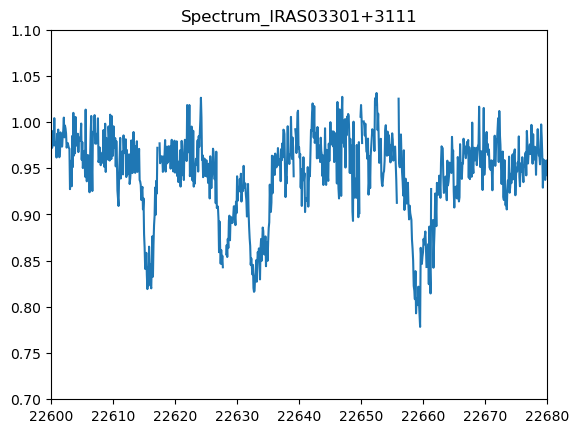

In [2]:
fname = "data/science/Spectrum_IRAS03301+3111.nspec"

# ProplydData is a simple class that stores the data and has some built-in methods
# to help with data processing
obj = ProplydData(fname)

# Let's nyquist sample the data. This assumes that we are using iSHELL 0.75'' slit width with is
# over sampled by 6 pixels per resolution element. We are bring it down to 2 (Nyquist)
# obj.Nyquist_bin_spectrum(N = 3)

obj.x *= 1  #e4  # convert x-axis to angstroms
# obj.x *= 1e4  # convert x-axis to angstroms

plt.figure()
plt.plot(obj.x, obj.y)
plt.ylim(0.7, 1.1)
plt.xlim(22600, 22680)
plt.title(obj.name)  # the object name was automatically set from the file name - see ProplyData.__init__()
plt.show()

## Guess doppler shift and change continuum normalization

First guess the doppler shift -> this process is fast, so you can try differnet pixel shift values

Same with the normalize regions array. It is possible to visually re-set normalizations.

The process for finding doppler shifts should probably be automated by doing some sort of cross-correlation.

renormalization of region  0  =  1.01
renormalization of region  1  =  1.015
renormalization of region  2  =  1.02
renormalization of region  3  =  1.01
renormalization of region  4  =  1.01
renormalization of region  5  =  1.01
renormalization of region  6  =  1.01


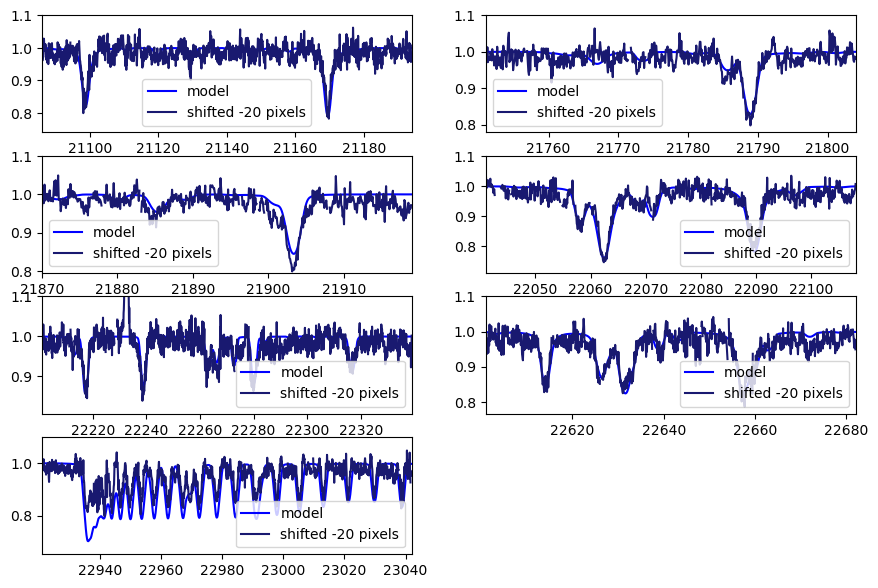

In [3]:
# Visually determine the doppler shift by plotting against a test model
# and shifting the data to match the model

guess_shift = -20  # shift in units of array indices
renormalize_regions= np.array([1.01,1.015,1.02,1.01,1.01,1.01,1.01])


obj_test = copy.deepcopy(obj)  # make a copy of the data while testing the doppler shift
obj_test.doppler_shift_data(guess_shift)  # apply the doppler shift


fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10.5,7))

#### Guess some parameters, it is importnat that the vsini and temperature are reasonable
#### to later find the wavelength shifts automatically

test_teff=3400
test_logg=3.25
test_rK=1.0
test_B=1.0
test_vsini=17


for r, ax in enumerate(axs.reshape(-1)):
    if r == 7:
        ax.axis("off")
        continue
    
    model = MoogStokesModel(test_teff, test_logg, rK=test_rK, B=test_B, vsini=test_vsini, region=r)
    ax.plot(model.x, model.y, c='blue', label="model")
    ax.set_ylim(min(model.y)-0.05,1.1)
    
    xlo, xhi = model.region_xlims(r)
    xdata, ydata, yerrdata = obj_test.get_range(xlo, xhi)  # get
    print('renormalization of region ', r,' = ' ,renormalize_regions[r])
    renorm_ydata,renorm_yerrdata = ydata*renormalize_regions[r], yerrdata**renormalize_regions[r]
    ax.plot(xdata, renorm_ydata, c='midnightblue', label="shifted "+str(guess_shift)+" pixels")
    #ax.plot(obj_test.x, obj_test.y, c='midnightblue', label="shifted "+str(shift)+" pixels")

    
    ax.set_xlim(xlo,xhi)
    ax.legend()

plt.show()

## Find doppler shift of each region automatically.
This code finds the doppler shift for each selected region (in pixels), by default all 6 regions and save them into an array.


In [4]:
shifts = automatic_wavelength_shifts_values(obj_test,Teff=test_teff, logg=test_logg,
                                            rK=test_rK, B=test_B, vsini=test_vsini,guess_shift=guess_shift)

print(shifts)

[-20. -19. -21. -20. -19. -19. -20.]


# Re-scale the errors

This portion rescales the errors to ensure reduced chi-square ~ 1. This is a way to make sure the uncertainties are not under or over reported, and it naturally assumes that the model is correct. 

In [5]:
# errors can also be re-scaled to a value that is appropriate depending on the reduced chi-squared
obj.rescale_yerr(33**0.5)

[yerr rescaled] Factor applied: 5.744562646538029. Total scaling so far: 5.744562646538029


## Fit the object across a grid with minimum chi-squared

This cell computes the chi-squared value for every model across the grid. NOTE: The grid search scales as n^5 so it will take a long time if the grid is large!

In [6]:
# Define the range of values for the grid. The sampling is coarse in this example.
Teff_vals = np.arange(3200, 4001, 200)
logg_vals = np.arange(3.0, 4.00, 0.25)
rK_vals = np.arange(1.0, 2.5, 0.1)
vsini_vals = np.arange(7, 22, 5)
B_vals = np.arange(0.5, 3.0, 0.5)

# Which wavelength regions should we fit? The regions are defined in the object spectra.MoogStokesModel.region_xlims().
# For example, setting regions = [0, 1, 2, 4, 5, 6] will skip region 3. This is useful if there are no lines in that
# region for the data.
regions = [0, 1, 2, 3, 4, 5, 6] #range(7)

filtered_shifts = shifts[regions]
filtered_renormalized_regions=renormalize_regions[regions]

# Fit the model across the grid - MAY TAKE A WHILE
chi2_grid = compute_moogstokes_chi2_grid(obj, Teff_vals, logg_vals, 
                                         rK_vals, vsini_vals, B_vals,
                                         renormalization=filtered_renormalized_regions,
                                         shifts=filtered_shifts, regions=regions)


1.01
1.015
1.02
1.01
1.01
1.01
1.01


In [7]:
# The variable chi2_grid contains the chi-squared values across the grid. If you want to get the model parameters
# that correspond to the lowest chi-squared, you can use this function
Teff_best, logg_best, rK_best, vsini_best, B_best = best_chi2_grid_params(chi2_grid, Teff_vals, logg_vals, rK_vals, vsini_vals, B_vals)

## Plot the best fit model

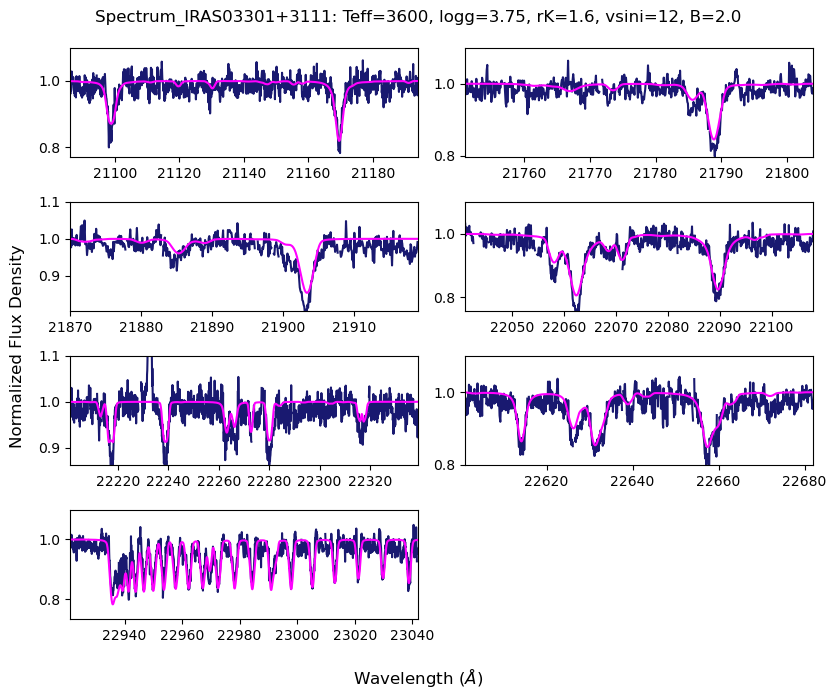

In [8]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(8.5,7))

for r, ax in enumerate(axs.reshape(-1)):
    if r == 7:
        ax.axis("off")
        continue

    # This is the best model we found
    model = MoogStokesModel(Teff=Teff_best, logg=logg_best, rK=rK_best, B=B_best, vsini=vsini_best, region=r)
    
    obj.doppler_shift_data(shifts[r])
    xlo, xhi = model.region_xlims(r)
    xdata, ydata, yerrdata = obj.get_range(xlo, xhi)  # get
    
    ax.plot(xdata, ydata*renormalize_regions[r], c='midnightblue')
    ax.plot(model.x, model.y, c='magenta')
#     ax.set_ylim(0.85,1.1)
    ax.set_ylim(min(model.y)-0.05,1.1)

    xlo, xhi = model.region_xlims(r)
    ax.set_xlim(xlo,xhi)
    obj.doppler_shift_data(-shifts[r])

fig.suptitle(f"{obj.name}: Teff={model.Teff}, logg={model.logg}, rK={round(model.rK,2)}, vsini={model.vsini}, B={model.B}")
fig.supxlabel(r"Wavelength ($\AA$)")
fig.supylabel(r"Normalized Flux Density")
plt.tight_layout()
fig.savefig(f"figures/model_plots/{obj.name}_Regions{regions}_Teff{model.Teff}_logg{model.logg}_rK{round(model.rK,2)}_vsini{model.vsini}_B{model.B}.png", dpi=98, facecolor="white")
plt.show()

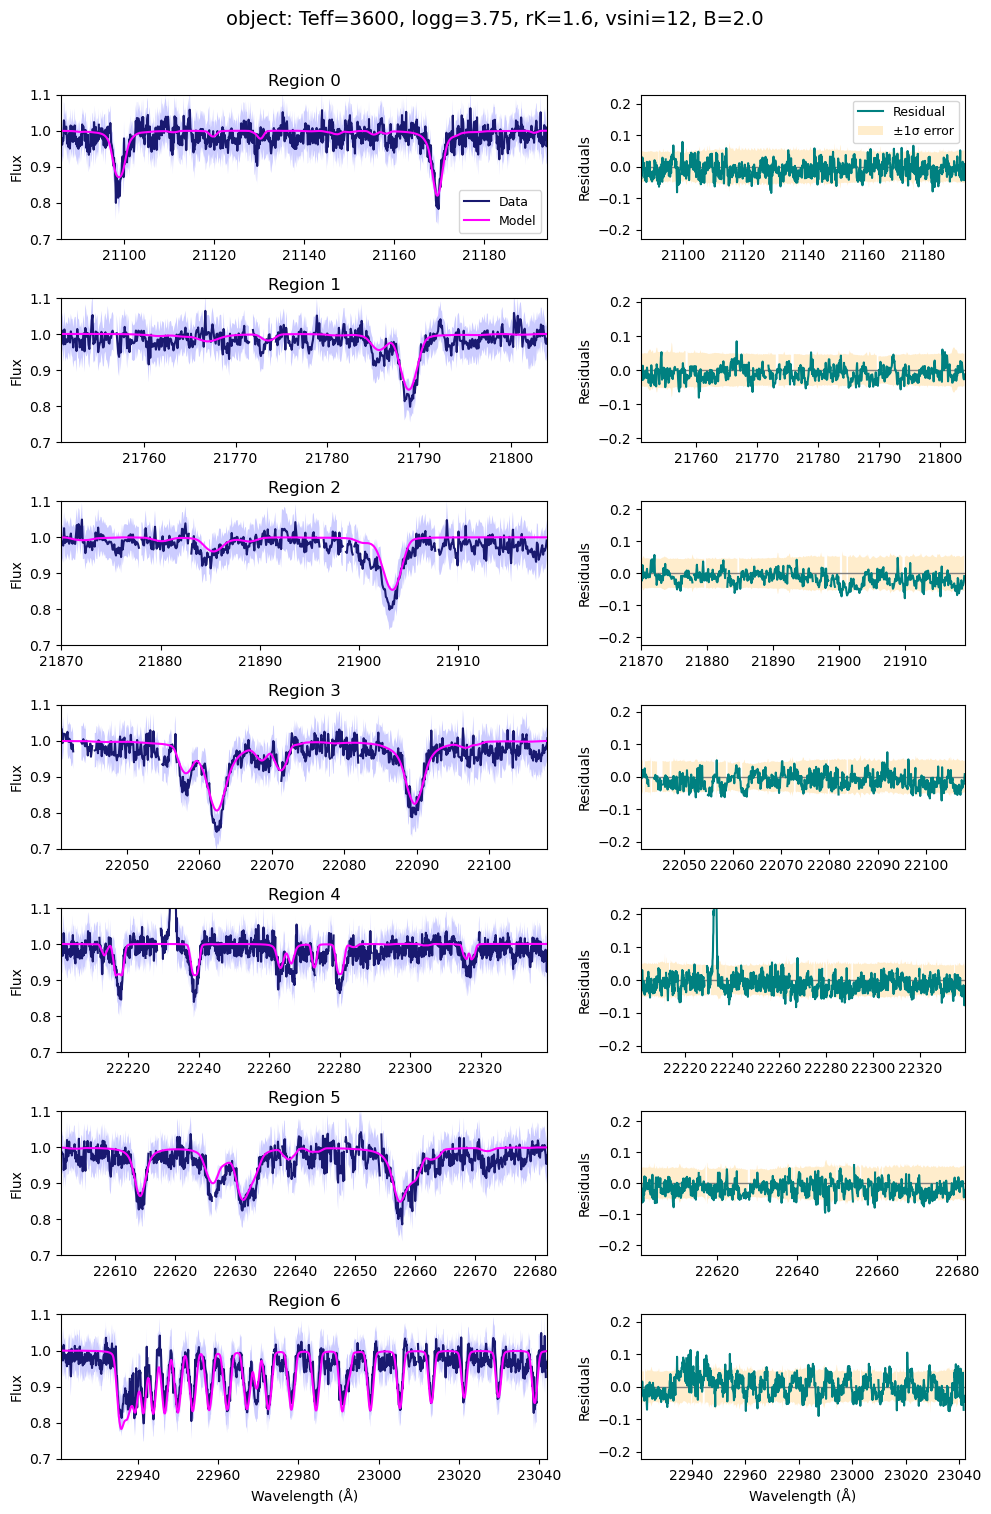

In [9]:
regions = [0, 1, 2, 3, 4, 5, 6]
best_params = (Teff_best, logg_best, rK_best, vsini_best, B_best)
plot_bestfit_and_residuals(data=obj, best_params=best_params, 
                           renormalization=renormalize_regions,
                           shifts=shifts, regions=regions, ylim=(0.7, 1.1))

# Reduced Chi-squared value

In [10]:
best_params = (Teff_best, logg_best, rK_best, vsini_best, B_best)
regions = [0, 1, 2, 3, 4, 5]  # or whatever regions you use

red_chi2 = compute_reduced_chi2_bestfit(data=obj, best_params=best_params, regions=regions)
print(f"Reduced chi-square at best fit: {red_chi2:.3f}")


Reduced chi-square at best fit: 0.978


# Chi-squared visualization

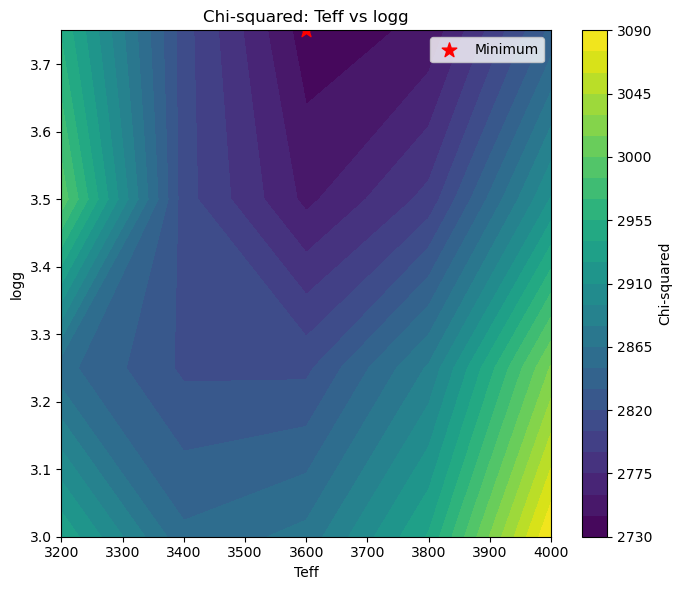

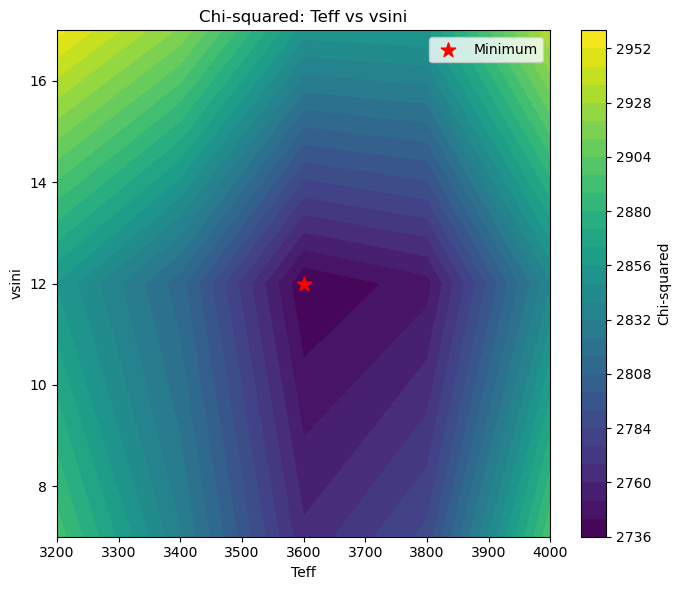

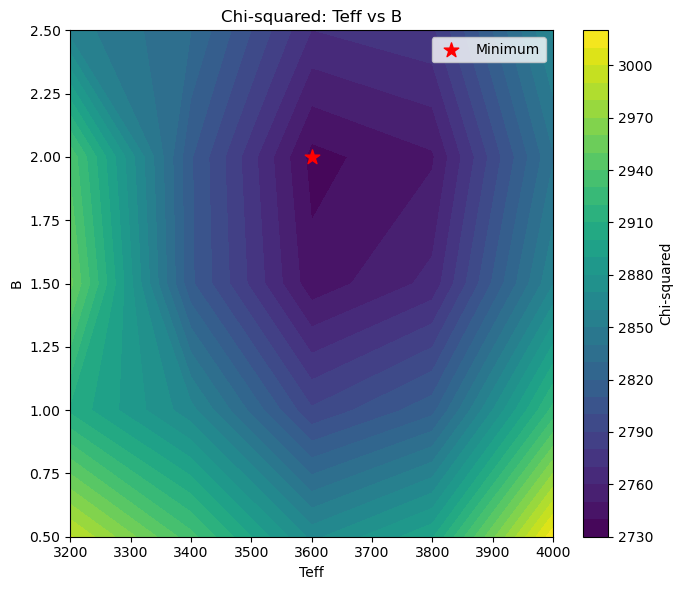

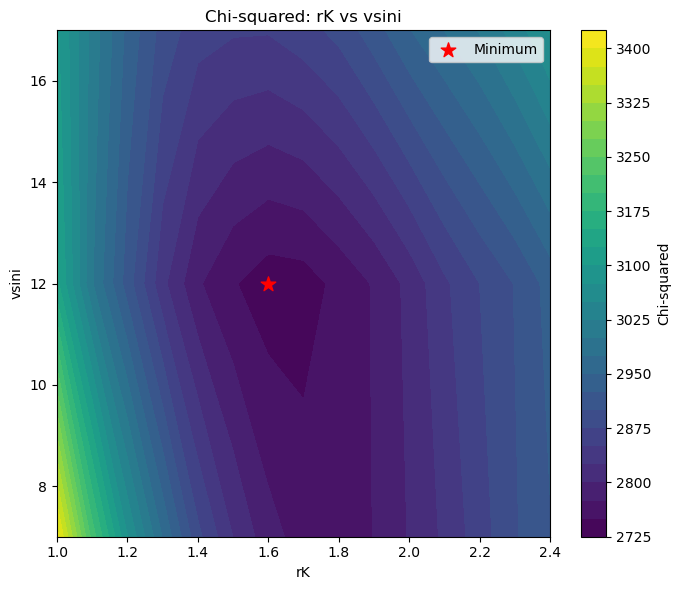

In [11]:
plot_chi2_slice(chi2_grid, Teff_vals, logg_vals, 'Teff', 'logg')
plot_chi2_slice(chi2_grid, Teff_vals, vsini_vals, 'Teff', 'vsini')
plot_chi2_slice(chi2_grid, Teff_vals, B_vals, 'Teff', 'B')
plot_chi2_slice(chi2_grid, rK_vals, vsini_vals, 'rK', 'vsini')

# Confidence intervals

In [12]:
param_grids = {'Teff': Teff_vals, 'logg': logg_vals, 'rK': rK_vals, 'vsini': vsini_vals, 'B': B_vals}
intervals = get_all_confidence_intervals(chi2_grid, param_grids, delta_chi2=1.0) # for 1 parameter at a time, 1-sigma
print(intervals)

{'Teff': (np.int64(3600), np.int64(3600)), 'logg': (np.float64(3.75), np.float64(3.75)), 'rK': (np.float64(1.6000000000000005), np.float64(1.6000000000000005)), 'vsini': (np.int64(12), np.int64(12)), 'B': (np.float64(2.0), np.float64(2.0))}


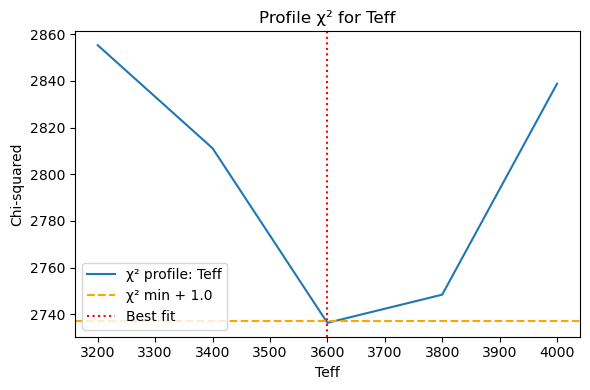

Best fit Teff: 3600
1.00 delta chi² confidence interval: (np.int64(3600), np.int64(3600))


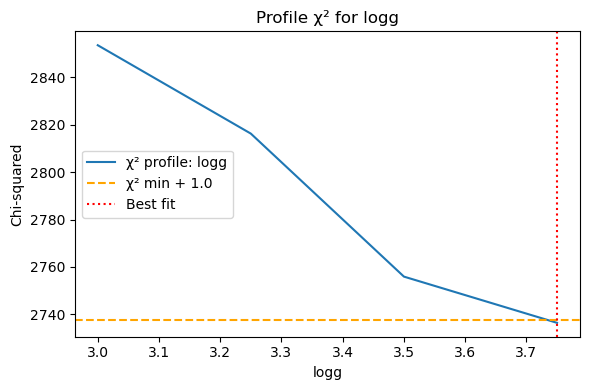

Best fit logg: 3.75
1.00 delta chi² confidence interval: (np.float64(3.75), np.float64(3.75))


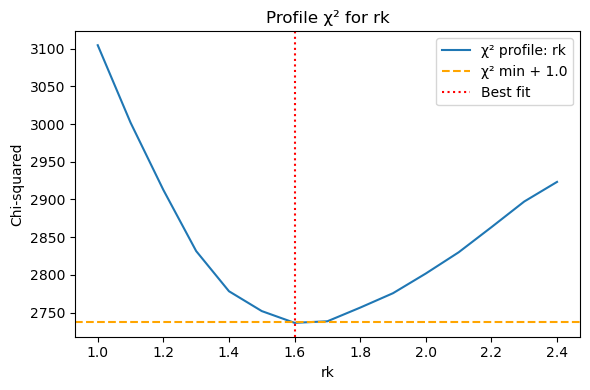

Best fit rk: 1.6000000000000005
1.00 delta chi² confidence interval: (np.float64(1.6000000000000005), np.float64(1.6000000000000005))


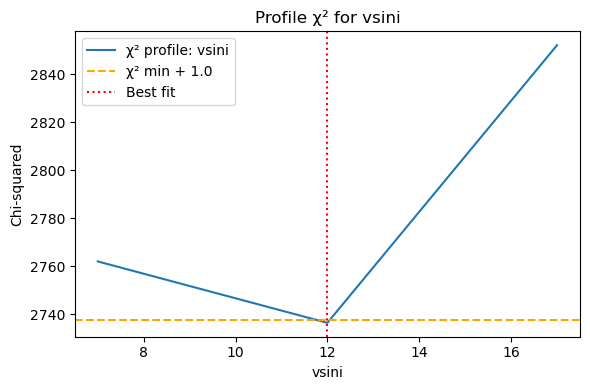

Best fit vsini: 12
1.00 delta chi² confidence interval: (np.int64(12), np.int64(12))


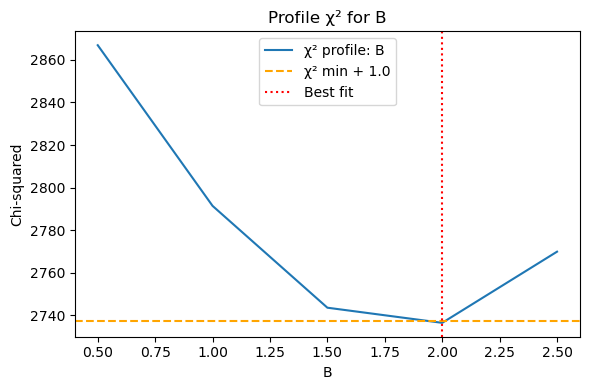

Best fit B: 2.0
1.00 delta chi² confidence interval: (np.float64(2.0), np.float64(2.0))


(np.float64(2.0), np.float64(2.0))

In [13]:
# For Teff (axis=0), 1-parameter interval:
plot_1d_chi2_profile(Teff_vals, chi2_grid, axis=0, param_name='Teff', delta_chi2=1.0)
plot_1d_chi2_profile(logg_vals, chi2_grid, axis=1, param_name='logg', delta_chi2=1.0)
plot_1d_chi2_profile(rK_vals, chi2_grid, axis=2, param_name='rk', delta_chi2=1.0)
plot_1d_chi2_profile(vsini_vals, chi2_grid, axis=3, param_name='vsini', delta_chi2=1.0)
plot_1d_chi2_profile(B_vals, chi2_grid, axis=4, param_name='B', delta_chi2=1.0)


# For logg (axis=1), etc.

## Plot with Feiden (2016) magnetic isochrones

In [14]:
# Import isochrones
model_ages = [1, 2, 4, 8, 15, 30, 50]          # in Myr
iso_models = []
folder = 'data/isochrones/'

for num in model_ages:
    fname= os.path.join(folder, f"dmestar_{float(num):07.1f}myr_z+0.00_a+0.00_phx.iso")

    arr = np.loadtxt(fname, skiprows=5).T
    m = arr[0]
    teff = 10**arr[1]      # convert from logTeff to Teff
    logg = arr[2]
    iso_models.append([m, teff, logg])

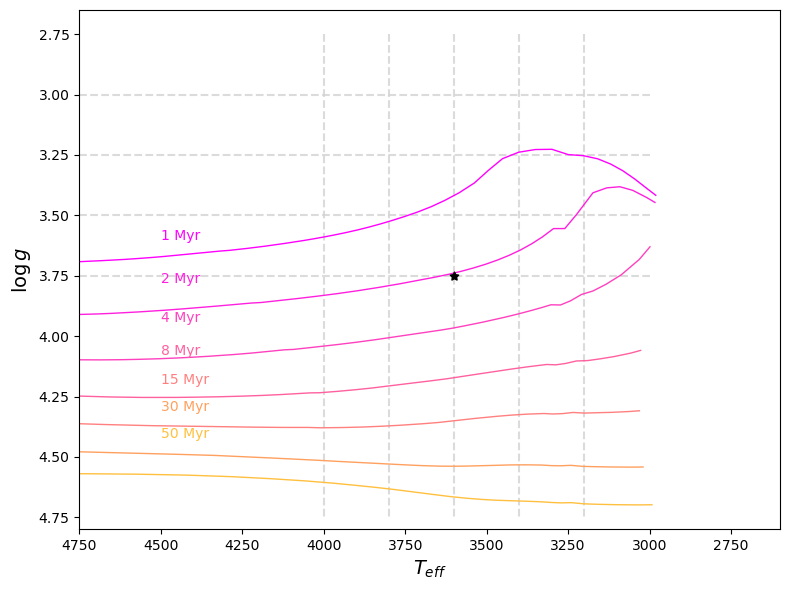

In [15]:
plt.figure(figsize=(8,6))

# Show objects as points
plt.scatter(Teff_best, logg_best, c='k', marker=(5, 1), s=40, zorder=2)

# Show grid of models
plt.vlines(Teff_vals, 2.75, 4.75, zorder=0, linestyles='--', colors='lightgray', alpha=0.8)
plt.hlines(logg_vals, 3000, 4800, zorder=0, linestyles='--', colors='lightgray', alpha=0.8)

# Plot isochrones and labels. Most of the complexity here is in shifting the text labels around so they
# look pretty on the figure...
n = 9
tshifts = [0, 0.02, 0.02, 0, -0.04, -0.09, -0.14]
colors = plt.cm.spring(np.linspace(0,1,n))
for i in range(len(model_ages)):
    plt.plot(iso_models[i][1], iso_models[i][2], zorder=1, label=str(model_ages[i]) + ' Myr', linewidth=1, c=colors[i])
    plt.text(4500, 3.6+0.16*i+tshifts[i], f"{model_ages[i]} Myr", c=colors[i], zorder=1)

plt.xlim(2600, 4750)
plt.ylim(2.65, 4.8)
plt.xlabel(r'$T_{eff}$', fontsize=14)
plt.ylabel(r'$\log g$', fontsize=14)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('figures/ages_test.png', facecolor='white', dpi=98)
plt.show()